In [ ]:
import torch
import torch.nn as nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch.nn.functional as F

In [ ]:
from torch.optim import Adam

In [ ]:
class RecurrentNet(nn.Module):

    def __init__(self, vocab_size, hidden_size, n, dropout):
        super(RecurrentNet, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n = n
        self.dropout = dropout

        self.layers = nn.ModuleList()
        for i in range(self.n):
            layer = {}
            layer['xh'] = nn.Linear(self.vocab_size if i == 0 else self.hidden_size, self.hidden_size)
            layer['hh'] = nn.Linear(self.hidden_size, self.hidden_size)
            self.layers.append(nn.ModuleDict(layer))

        self.Why = nn.Linear(self.hidden_size, self.vocab_size)
        self.dropout_layer = nn.Dropout(self.dropout) if self.dropout > 0 else None

    def forward(self, x, hidden_states):
        outputs = []
        for i in range(self.n):
            inp = x if i == 0 else outputs[-1]
            if self.dropout_layer and i > 0:
                inp = self.dropout_layer(inp)

            out = torch.tanh(self.layers[i]['hh'](hidden_states[i]) + self.layers[i]['xh'](inp))
            outputs.append(out)

        top_h = outputs[-1]
        if self.dropout_layer:
            top_h = self.dropout_layer(top_h)

        logits = self.Why(top_h)
        s_logits = logits/0.8
        logs = nn.LogSoftmax(dim=-1)
        out = logs(s_logits)
        outputs.append(out)
        return out, outputs




In [ ]:
def initialize_hidden_states(batch_size, hidden_size, num_layers):
    return [torch.zeros(batch_size, hidden_size) for _ in range(num_layers)]

In [ ]:
pip install python-docx

In [ ]:
import docx

doc = docx.Document('/content/drive/MyDrive/y-comb-list.docx')
text = ''
for para in doc.paragraphs:
    text += para.text
    if(text[-1]!='.'):text+='.'

In [ ]:
stoi = {x:y+1 for y,x in enumerate(sorted(list(set(''.join(text)))))}


len(stoi)

itos = {y+1:x for y,x in enumerate(sorted(list(set(''.join(text)))))}


In [ ]:
stoi

{'\t': 1,
 ' ': 2,
 '!': 3,
 '"': 4,
 '#': 5,
 '$': 6,
 '%': 7,
 '&': 8,
 "'": 9,
 '(': 10,
 ')': 11,
 '*': 12,
 '+': 13,
 ',': 14,
 '-': 15,
 '.': 16,
 '/': 17,
 '0': 18,
 '1': 19,
 '2': 20,
 '3': 21,
 '4': 22,
 '5': 23,
 '6': 24,
 '7': 25,
 '8': 26,
 '9': 27,
 ':': 28,
 ';': 29,
 '=': 30,
 '?': 31,
 'A': 32,
 'B': 33,
 'C': 34,
 'D': 35,
 'E': 36,
 'F': 37,
 'G': 38,
 'H': 39,
 'I': 40,
 'J': 41,
 'K': 42,
 'L': 43,
 'M': 44,
 'N': 45,
 'O': 46,
 'P': 47,
 'Q': 48,
 'R': 49,
 'S': 50,
 'T': 51,
 'U': 52,
 'V': 53,
 'W': 54,
 'X': 55,
 'Y': 56,
 'Z': 57,
 '[': 58,
 ']': 59,
 '^': 60,
 'a': 61,
 'b': 62,
 'c': 63,
 'd': 64,
 'e': 65,
 'f': 66,
 'g': 67,
 'h': 68,
 'i': 69,
 'j': 70,
 'k': 71,
 'l': 72,
 'm': 73,
 'n': 74,
 'o': 75,
 'p': 76,
 'q': 77,
 'r': 78,
 's': 79,
 't': 80,
 'u': 81,
 'v': 82,
 'w': 83,
 'x': 84,
 'y': 85,
 'z': 86,
 'é': 87,
 '—': 88}

In [ ]:
text[:1000]

"Do Things that Don't Scale.July 2013.One of the most common types of advice we give at Y Combinator is to do things that don't scale. A lot of would-be founders believe that startups either take off or don't. You build something, make it available, and if you've made a better mousetrap, people beat a path to your door as promised. Or they don't, in which case the market must not exist. [1].Actually startups take off because the founders make them take off. There may be a handful that just grew by themselves, but usually it takes some sort of push to get them going. A good metaphor would be the cranks that car engines had before they got electric starters. Once the engine was going, it would keep going, but there was a separate and laborious process to get it going.Recruit.The most common unscalable thing founders have to do at the start is to recruit users manually. Nearly all startups have to. You can't wait for users to come to you. You have to go out and get them.Stripe is one of t

In [ ]:
x = [stoi[x] for x in text[:20]]
y = [stoi[x] for x in text[1:21]]

In [ ]:
x = torch.tensor(x)

In [ ]:
y = torch.tensor(y)
y.shape

torch.Size([20])

In [ ]:
oneh = F.one_hot(x, num_classes = len(stoi)).float()

In [ ]:
oneh.shape

torch.Size([20, 88])

In [ ]:
model = RecurrentNet(len(stoi), 256, 2, 0.5)

In [ ]:
for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model1 = model1.to(device)

In [ ]:
sum = 0
for p in model.parameters():
    if(len(p.shape)>1):sum += p.shape[0]*p.shape[1]
    else:sum += p.shape[0]
print(sum)

242776


In [ ]:
loss_cache = []
epochs_cache = []

In [ ]:
def train(model, text, stoi, itos, bs, epochs, lr, loss_cache, epochs_cache):

    text_indices = [stoi[char] for char in text]

    for epoch in range(epochs):
        ix = int(torch.randint(0, len(text), (1,)))
        hidden_states = initialize_hidden_states(1, model.hidden_size, model.n)
        if ix + bs < len(text_indices) - 1:
            x = torch.tensor(text_indices[ix:ix+bs])-1
            y_true = torch.tensor(text_indices[ix+1:ix+bs+1])-1
            logits = []
            for i in range(bs):
              oneh = F.one_hot(x[i], num_classes=len(stoi)).float()
              logit, hidden_states = model(oneh, hidden_states)
              logits.append(logit)
            logits = (torch.cat(logits, dim = 0))
            loss = F.cross_entropy(logits, y_true)

            with torch.no_grad():
              for p in model.parameters():
                  p.grad = None
            loss_cache.append(loss.item())
            epochs_cache.append(epoch)
            loss.backward()

            with torch.no_grad():
              for p in model.parameters():
                if p.grad is not None:
                  p.data += -lr*p.grad


            if (epoch) % 1000 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")


In [ ]:
train(model, text, stoi, itos, 32, 40000, 0.01, loss_cache, epochs_cache)

Epoch [1/40000], Loss: 5.109608173370361
Epoch [1001/40000], Loss: 2.8962416648864746
Epoch [2001/40000], Loss: 2.84354829788208
Epoch [3001/40000], Loss: 2.503660202026367
Epoch [4001/40000], Loss: 2.592172145843506
Epoch [5001/40000], Loss: 2.4172792434692383
Epoch [6001/40000], Loss: 2.0611226558685303
Epoch [7001/40000], Loss: 2.7550463676452637
Epoch [8001/40000], Loss: 2.636953830718994
Epoch [9001/40000], Loss: 2.6404354572296143
Epoch [10001/40000], Loss: 2.1108481884002686
Epoch [11001/40000], Loss: 2.465562105178833
Epoch [12001/40000], Loss: 2.3402271270751953
Epoch [13001/40000], Loss: 2.219975709915161
Epoch [14001/40000], Loss: 2.2328696250915527
Epoch [15001/40000], Loss: 2.619492292404175
Epoch [16001/40000], Loss: 2.0909955501556396
Epoch [17001/40000], Loss: 2.566521644592285
Epoch [18001/40000], Loss: 2.5214121341705322
Epoch [19001/40000], Loss: 2.1283276081085205
Epoch [20001/40000], Loss: 2.7904622554779053
Epoch [21001/40000], Loss: 2.044032335281372
Epoch [22001

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

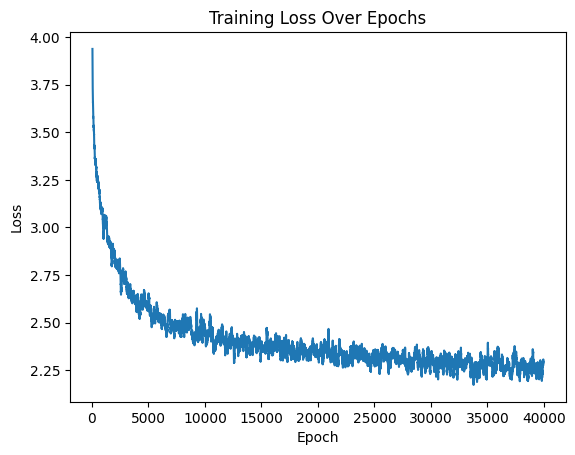

In [ ]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')
window_size = 100
smoothed_loss = moving_average(loss_cache, window_size)
smoothed_epochs = moving_average(epochs_cache, window_size)

plt.plot(smoothed_epochs, smoothed_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()


In [ ]:
sample = ""
seq = 'Company '
hidden_states = [torch.zeros(1, 256) for i in range(2)]
while(len(seq)<10000):
   x = torch.tensor([stoi[i] for i in seq])-1
   for i in range(len(seq)):
    oneh = F.one_hot(x[i], num_classes = len(stoi)).float()

    out,hidden_states = model(oneh,hidden_states)
    exp_probs = torch.exp(out)
    # Normalize to obtain the softmax probabilities
    softmax_probs = exp_probs / torch.sum(exp_probs, dim=-1, keepdim=True)
   nx = itos[int(torch.multinomial(softmax_probs,num_samples = 1)) + 1]
   seq += nx

print(seq)


KeyboardInterrupt: 

In [ ]:
seq

"Company s oha lot tha ticarxuntit.WAnd aisestonela demVcis lak it be ineppeangtist, sucd on butt rave as. Wor ssunter, sukenJ of;; nen hetore. Bhat id you'll tho gead fu hut'ro.II dyaus ane ponse doe wsor thes ceneect pa in is whacrdecruab? Bal the seg tep, alpiigs. Iupsnsorsthnuwall do worrgioniths toony valy on weth?red fdedial st whus mteluy, anit, Yo —ancenta sf.od fly aecanithea forrnf jive whe phen siower. (ounerst Soma to soord ut? [ove of gatere asprise,d to bleaith y poupsinat, indn't hewe wand chal ton caude t, Tha lund  o&venvor. Fha beap iis, an the ahal colad in t of umede speouls yoh herkore dicindey goud in warbesentermiled. Bpingab yog ta. [eg you tha kind in't meistn too udenw rak sersure mene we pery walt do the plockmont peexund a dtelruttr g en expertenteore suther uedeios of s. Ber paod yo ontingel me orat angallig s mostopex at oo b ch oncarfupdo a jon dovedthine, Im whave prrrke Hly, the fren"

In [ ]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
class LSTMNet(nn.Module):

    def __init__(self, vocab_size, hidden_size, n_layers, dropout):
        super(LSTMNet, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout

        self.layers = nn.ModuleList()

        for i in range(self.n_layers):
            l = {}
            l['Whf'] = nn.Linear(self.hidden_size, self.hidden_size)
            l['Whi'] = nn.Linear(self.hidden_size, self.hidden_size)
            l['WhO'] = nn.Linear(self.hidden_size, self.hidden_size)
            l['Whg'] = nn.Linear(self.hidden_size, self.hidden_size)
            l['Wxf'] = nn.Linear(self.vocab_size if i == 0 else self.hidden_size, self.hidden_size)
            l['Wxi'] = nn.Linear(self.vocab_size if i == 0 else self.hidden_size, self.hidden_size)
            l['WxO'] = nn.Linear(self.vocab_size if i == 0 else self.hidden_size, self.hidden_size)
            l['Wxg'] = nn.Linear(self.vocab_size if i == 0 else self.hidden_size, self.hidden_size)
            self.layers.append(nn.ModuleDict(l))

        self.sigmoid = nn.Sigmoid()
        self.decoder = nn.Linear(self.hidden_size, self.vocab_size)
        self.dropout_layer = nn.Dropout(self.dropout) if self.dropout > 0 else None

    def forward(self, x, hidden_states, cell_states):
        cstates = []
        outputs = []

        for i in range(self.n_layers):
            inp = x if i == 0 else outputs[-1]

            f = self.sigmoid(self.layers[i]['Whf'](hidden_states[i]) + self.layers[i]['Wxf'](inp))
            ix = self.sigmoid(self.layers[i]['Whi'](hidden_states[i]) + self.layers[i]['Wxi'](inp))
            o = self.sigmoid(self.layers[i]['WhO'](hidden_states[i]) + self.layers[i]['WxO'](inp))
            g = torch.tanh(self.layers[i]['Whg'](hidden_states[i]) + self.layers[i]['Wxg'](inp))

            cstate = f * cell_states[i] + ix * g

            cstates.append(cstate)

            out = o * torch.tanh(cstate)

            outputs.append(out)

        top_h = outputs[-1]
        if self.dropout_layer:
            top_h = self.dropout_layer(top_h)

        logits = self.decoder(top_h)
        s_logits = logits/0.8
        logs = nn.LogSoftmax(dim=-1)
        out = logs(s_logits)
        return out, outputs, cstates

In [ ]:
lstmodel = LSTMNet(len(stoi), 128, 2, 0.3)

In [ ]:
sum = 0
for p in lstmodel.parameters():
    if(len(p.shape)>1):sum += p.shape[0]*p.shape[1]
    else:sum += p.shape[0]
print(sum)

255064


In [ ]:
def initialize_hidden_states(batch_size, hidden_size, num_layers):
    return [torch.zeros(batch_size, hidden_size) for _ in range(num_layers)]
hidden_states = initialize_hidden_states(1, lstmodel.hidden_size, lstmodel.n_layers)

In [ ]:
for i in range(lstmodel.n_layers-1):
    inp = torch.randn(1,88)
    f = lstmodel.sigmoid(lstmodel.layers[i]['Whf'](hidden_states[i]) + lstmodel.layers[i]['Wxf'](inp))
    i = lstmodel.sigmoid(lstmodel.layers[i]['Whi'](hidden_states[i]) + lstmodel.layers[i]['Wxi'](inp))
    print(lstmodel.layers[i])#['Who'].shape)
    # o = lstmodel.sigmoid(lstmodel.layers[i]['Who'](hidden_states[i]) + lstmodel.layers[i]['Wxo'](inp))
    g = torch.tanh(lstmodel.layers[i]['Whg'](hidden_states[i]) + lstmodel.layers[i]['Wxg'](inp))


TypeError: only integer tensors of a single element can be converted to an index

In [ ]:
def train(model, text, stoi, itos, bs, epochs, lr, loss_cache, epochs_cache):

    text_indices = [stoi[char] for char in text]

    for epoch in range(epochs):
        ix = int(torch.randint(0, len(text), (1,)))

        if ix + bs < len(text_indices) - 1:
            hidden_states = initialize_hidden_states(1, lstmodel.hidden_size, lstmodel.n_layers)
            cstates = initialize_hidden_states(1, lstmodel.hidden_size, lstmodel.n_layers)
            x = torch.tensor(text_indices[ix:ix+bs])-1
            y_true = torch.tensor(text_indices[ix+1:ix+bs+1])-1
            logits = []
            for i in range(bs):
              oneh = F.one_hot(x[i], num_classes=len(stoi)).float()
              logit, hidden_states, cstates = model(oneh, hidden_states, cstates)
              logits.append(logit)
            logits = torch.cat(logits, dim = 0)
            loss = F.cross_entropy(logits, y_true)

            with torch.no_grad():
              for p in model.parameters():
                  p.grad = None
            loss_cache.append(loss.item())
            epochs_cache.append(epoch)
            loss.backward()

            with torch.no_grad():
              for p in model.parameters():
                if p.grad is not None:
                  p.data += -lr*p.grad


            if (epoch) % 1000 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{ix//bs}], Loss: {loss.item()}")

In [ ]:
train(lstmodel, text, stoi, itos, 50, 10000, 0.01, loss_cache, epochs_cache)

Epoch [1/10000], Step [12072], Loss: 4.480090141296387
Epoch [1001/10000], Step [7363], Loss: 3.2227859497070312
Epoch [2001/10000], Step [5662], Loss: 3.087271213531494
Epoch [3001/10000], Step [6310], Loss: 2.870457172393799
Epoch [4001/10000], Step [1885], Loss: 3.3015127182006836
Epoch [5001/10000], Step [2693], Loss: 2.890566349029541
Epoch [6001/10000], Step [6639], Loss: 3.028610944747925
Epoch [7001/10000], Step [11595], Loss: 3.0691945552825928


KeyboardInterrupt: 